# Modelling and Evaluation

## Objectives

* Answer business requirement 2: **The client is interested in predicting if a cherry leaf is healthy or contains powdery mildew.**

## Inputs

* inputs/cherry_leaves_dataset/train
* inputs/cherry_leaves_dataset/test
* inputs/cherry_leaves_dataset/validation
* image_shape

## Outputs

* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file

---------------------------

# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

-----------

# Set working directories

In [2]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspaces/mildew-detection'

### Set input directory 

In [5]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names 

In [7]:
labels = os.listdir(train_path)
print('Labels for the images are', labels)

Labels for the images are ['healthy', 'powdery_mildew']


### Set image shape

In [8]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

------------------

# Plot the number of images in train, test, and validation datasets

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images




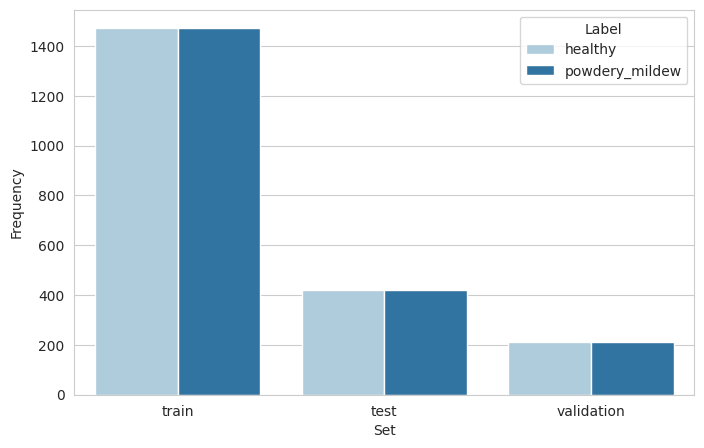

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'test', 'validation']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label', palette='Paired')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

-------------

# Image data augmentation

As the above plot indicates, the dataset is not large enough. To solve this, we data augmentation technique which will artificially add data to the datasets. To do this, import ImageDataGenerator from Tensorflow. 

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Initialise ImageDataGenerator

In [11]:
augmented_image_data = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True, 
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255
)

#### Batch size

In [12]:
batch_size = 21 #To be used when augmenting the datasets

#### Augment training image

In [13]:
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )
train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment test image

In [14]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )
test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

#### Augment validation image

In [15]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )
validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot Augmented images

Training set image

(21, 256, 256, 3)


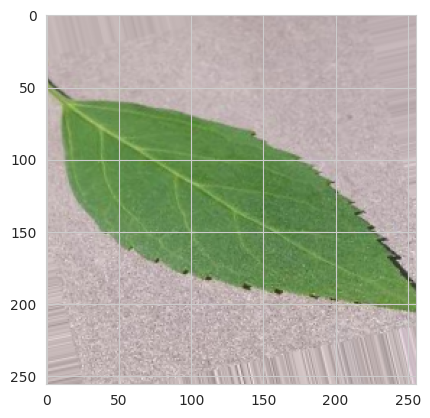

(21, 256, 256, 3)


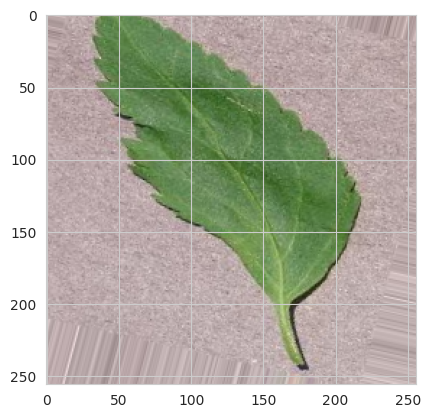

(21, 256, 256, 3)


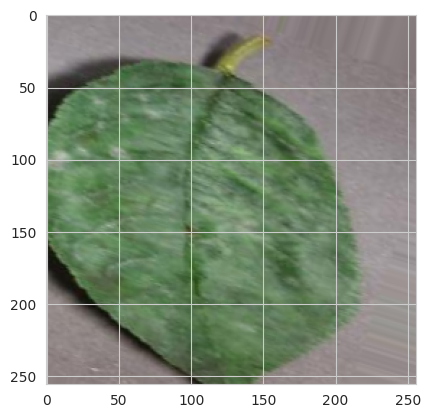

In [16]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Test set image

(21, 256, 256, 3)


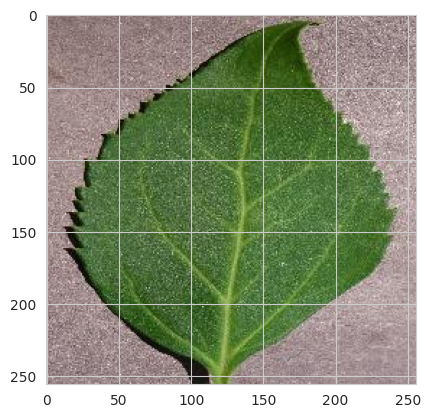

(21, 256, 256, 3)


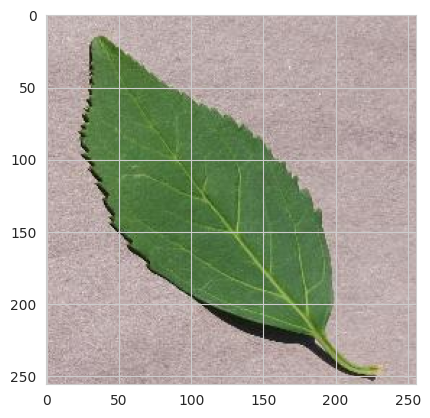

(21, 256, 256, 3)


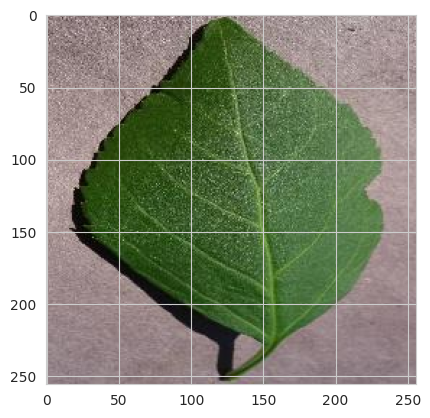

In [17]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Validation set image

(21, 256, 256, 3)


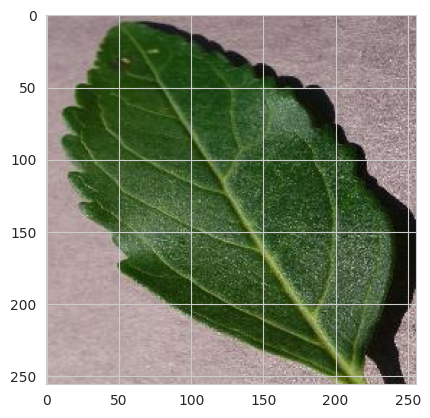

(21, 256, 256, 3)


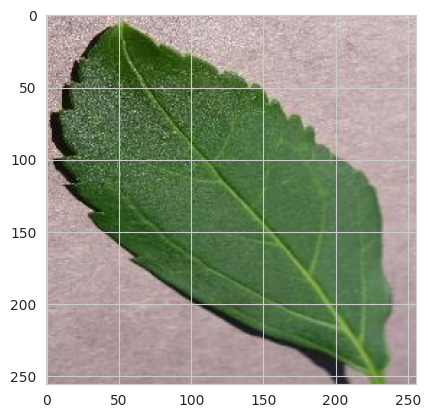

(21, 256, 256, 3)


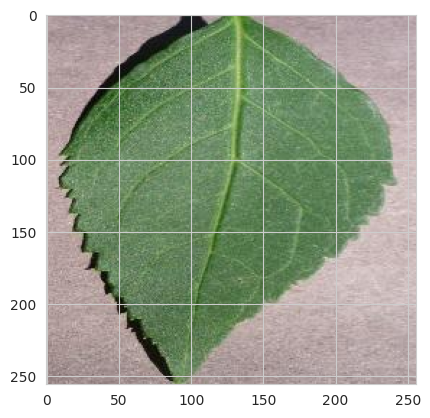

In [18]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

Save class_indices

In [19]:
joblib.dump(value=train_set.class_indices,
           filename=f'{file_path}/class_indices.pkl')

['outputs/v1/class_indices.pkl']

---------------

# Creating the ML Model

#### Import packages

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [21]:
def create_model():
    model = Sequential()

    model.add(Conv2D(filters=16, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(32, activation='relu'))

    model.add(Dropout(0.6))
    model.add(Dense(1, activation='tanh'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [22]:
create_model().summary()

2023-09-29 11:31:50.027670: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

Early stopping. To stop the model training in case of overfitting or uderfitting of the model.

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit the model for model training

In [24]:
model = create_model()
model.fit(train_set,
          epochs=20,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1)

2023-09-29 11:32:08.807764: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
140/140 [==============================] - 196s 1s/step - loss: 0.8090 - accuracy: 0.7373 - val_loss: 1.0761 - val_accuracy: 0.8643
Epoch 2/20
140/140 [==============================] - 150s 1s/step - loss: 0.1016 - accuracy: 0.9730 - val_loss: 0.2036 - val_accuracy: 0.9810
Epoch 3/20
140/140 [==============================] - 145s 1s/step - loss: 0.0486 - accuracy: 0.9887 - val_loss: 0.1425 - val_accuracy: 0.9833
Epoch 4/20
140/140 [==============================] - 149s 1s/step - loss: 0.0650 - accuracy: 0.9843 - val_loss: 0.5702 - val_accuracy: 0.9310
Epoch 5/20
140/140 [==============================] - 150s 1s/step - loss: 0.1401 - accuracy: 0.9658 - val_loss: 0.1258 - val_accuracy: 0.9857
Epoch 6/20
140/140 [==============================] - 156s 1s/step - loss: 0.0239 - accuracy: 0.9932 - val_loss: 0.0852 - val_accuracy: 0.9833
Epoch 7/20
140/140 [==============================] - 161s 1s/step - loss: 0.0128 - accuracy: 0.9949 - val_loss: 0.1020 - val_accuracy: 0.9833

## Save Model

In [25]:
model.save('outputs/v1/mildew_detector_model.h5')

----------------------

# Model Performance

### Model learning curve

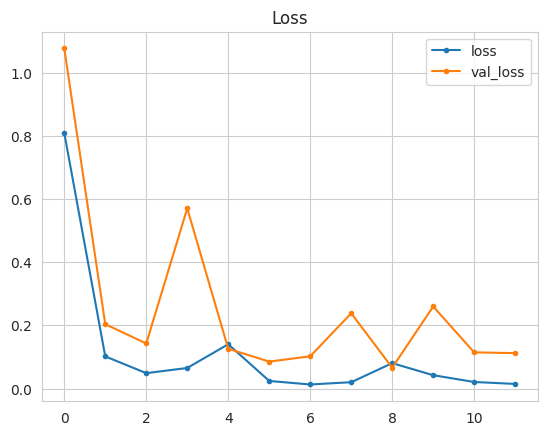

/n


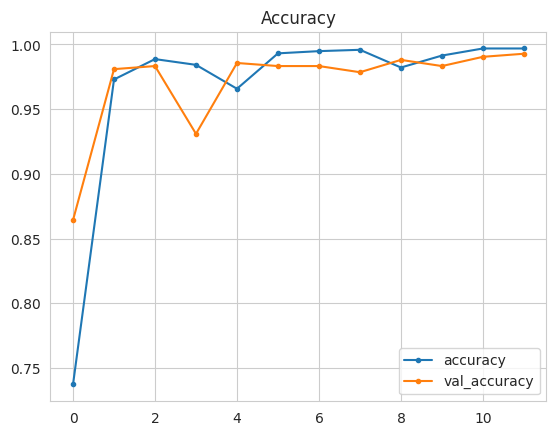

In [27]:
losses = pd.DataFrame(model.history.history)
sns.set_style('whitegrid')
losses[['loss','val_loss']].plot(style='.-')
plt.title('Loss')
plt.savefig(f'{file_path}/model_training_losses.png', 
            bbox_inches='tight', dpi=150)
plt.show()

print('/n')

losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title('Accuracy')
plt.savefig(f'{file_path}/model_training_accuracy.png', 
            bbox_inches='tight', dpi=150)
plt.show()


-----------------------

# Model Evaluation

## Load saved model

In [34]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.h5')


## Evaluate model on test set

For the model to meet the success criteria, the accuracy needs to be 97%(0.9700)

In [29]:
evaluation = model.evaluate(test_set)

41/41 [==============================] - 11s 251ms/step - loss: 0.0741 - accuracy: 0.9953


## Save Evaluation pickle

In [30]:
joblib.dump(value=evaluation, filename=f'outputs/v1/evaluation.pkl')

['outputs/v1/evaluation.pkl']

------------

# Predict on new data

Load a random image

Image shape: (256, 256), Image mode: RGB


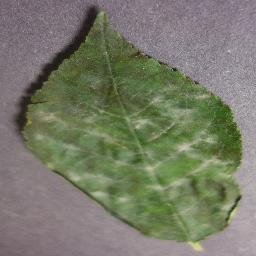

In [35]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[1] # Picking a leaf image with powdery mildew
pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image


Convert the image into an array so that the model can predict

In [36]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict

In [38]:
prediction_prob = model.predict(my_image)[0,0]
target_map = {v: k for k, v in train_set.class_indices.items()}
prediction_class = target_map[prediction_prob > 0.5]
if prediction_class == target_map[0]:
    prediction_prob = 1 - prediction_prob

print(prediction_prob)
print(prediction_class)

1.0
powdery_mildew
